# Code for generating Figure 5 and SFig 5 panels from derivative data

#### Raw code for generating derivative data is in analysis1_compute_regional_RDMs.py (using default parameters for main text figures)

`python analysis1_compute_regional_RDMs.py`

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nilearn.plotting as plotting
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
import statsmodels.api as sm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.sandbox.stats.multicomp as mc
import bct
import scipy
import statsmodels.formula.api as smf

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [26]:
figuredir = '../figures/Fig5/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']
sensorynets = ['vis1','vis2','aud']
motornets = ['smn']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
def calc_loglikelihood(n, y, ypred):
    lnL = 0.5 * (-n * (np.log(2*np.pi) + 1 - np.log(n) + np.log(sum((y-ypred)**2))));
    return lnL

def exponentialdecay(n0,decay,x):
    return n0*np.exp(-decay*x)

boxpalette = [sns.color_palette("Set2")[0], sns.color_palette("Set2")[2]]
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Load multi-task representational dimensionality and margulies gradients

In [4]:
df_dim = pd.read_csv('../processed_data/analysis1/analysis1_parcel_cosine_dimensionality.csv')
avg_dim = []
for i in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    avg_dim.append(df_dim.Dimensionality[df_dim.Parcels==i+1].mean())
avg_dim = np.asarray(avg_dim)


# Gradient 1

In [7]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# ListedColormap(colormap.colors[::-1])

newcmp = ListedColormap(newcolors[::-1], name='OrangeBlue')

parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')


# Load and visualize representational distance

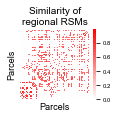

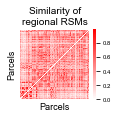

In [9]:
distance = 'cosine'
rep_dist_mat = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosineRSMs.csv')
rep_dist_mat_unthresh = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosineRSMs_unthresholded.csv')
# np.fill_diagonal(rep_dist_mat,0)
sorted_mat = rep_dist_mat[indsort,indsort.T]
plt.figure(figsize=(1.75,1.75))
# plt.subplot(121)
ax = sns.heatmap(sorted_mat,center=0,cmap='bwr',square=True,cbar_kws={'fraction':0.046})
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=6)
plt.xlabel("Parcels",fontsize=9);
plt.ylabel("Parcels",fontsize=9);
plt.title('Similarity of\nregional RSMs',fontsize=10)
plt.xticks([]);
plt.yticks([]);
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(figuredir + 'Interregion_RDM_similarity_thresholded.png',dpi=300)

#
plt.figure(figsize=(1.75,1.75))
# plt.subplot(122)
sorted_mat = rep_dist_mat_unthresh[indsort,indsort.T]
ax = sns.heatmap(sorted_mat,center=0,cmap='bwr',square=True,cbar_kws={'fraction':0.046})
plt.xlabel("Parcels",fontsize=9);
plt.ylabel("Parcels",fontsize=9);
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=6)
plt.title('Similarity of\nregional RSMs',fontsize=10)
plt.xticks([]);
plt.yticks([]);
ax.invert_yaxis()
plt.tight_layout()
plt.savefig(figuredir + 'Interregion_RDM_similarity_unthresholded.png',dpi=300)

#### Load and visualize on surface the gradients of representational distance matrix

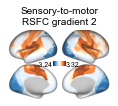

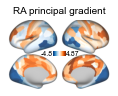

In [12]:
rsm_gradients = np.loadtxt('../processed_data/analysis1/analysis1_cosine_3components_cosineRSMs_representational_gradients.csv')

vrange = 2
if not os.path.exists(figuredir + 'Parcellated_InterRegionalRepSimilarity.png'):
    tmp = np.hstack((rsm_gradients[180:,0],rsm_gradients[:180,0]))
    tmp = stats.zscore(tmp)
#     vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'Parcellated_InterRegionalRepSimilarity.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)

if not os.path.exists(figuredir + 'Parcellated_MarguliesGradient2.png'):
    tmp = np.hstack((parcellated_gradients[180:,1],parcellated_gradients[:180,1]))
    tmp = stats.zscore(tmp)
#     vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'Parcellated_MarguliesGradient2.png',tmp,vrange=(-vrange,vrange),cmap=newcmp)

fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'Parcellated_MarguliesGradient2.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Sensory-to-motor\nRSFC gradient 2',fontsize=10)
vmin, vmax = np.min(parcellated_gradients[:,1]), np.max(parcellated_gradients[:,1])
# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'IO_RSFCGrad2.png',dpi=300,transparent=True)
    
fig = plt.figure(figsize=(1.75,1.75))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'Parcellated_InterRegionalRepSimilarity.png') 
plt.imshow(im)
plt.axis('off')
plt.title('RA principal gradient',fontsize=10)
vmin, vmax = np.min(rsm_gradients[:,0]), np.max(rsm_gradients[:,0])
# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'RAGradientSurface.png',dpi=300,transparent=True)


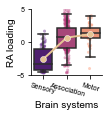

In [16]:
df_system = {}
df_system['Loading'] = []
df_system['LoadingIndex'] = []
df_system['System'] = []
df_system['Parcel'] = []

sorted_ragradient_ind = np.argsort(rsm_gradients[:,0])

for net in sensorynets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Loading'].append(rsm_gradients[roi,0])
        ind = np.where(sorted_ragradient_ind==roi)[0][0]
        df_system['LoadingIndex'].append(ind)
        df_system['System'].append('Sensory')
        df_system['Parcel'].append(roi)

for net in associationnets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Loading'].append(rsm_gradients[roi,0])
        ind = np.where(sorted_ragradient_ind==roi)[0][0]
        df_system['LoadingIndex'].append(ind)
        df_system['System'].append('Association')
        df_system['Parcel'].append(roi)
        
for net in motornets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Loading'].append(rsm_gradients[roi,0])
        ind = np.where(sorted_ragradient_ind==roi)[0][0]
        df_system['LoadingIndex'].append(ind)
        df_system['System'].append('Motor')
        df_system['Parcel'].append(roi)


df_system = pd.DataFrame(df_system)

plt.figure(figsize=(1.7,1.7))
ax = sns.boxplot(x="System",y="Loading",sym='',whis=[2.5,97.5],data=df_system,palette='magma') #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="System",y="Loading",alpha=0.4,s=3,data=df_system,palette='magma',zorder=0)
tmp = df_system.groupby('System',sort=False).mean()
# y = tmp.Dimensionality.values
sns.lineplot(x="System",y="Loading",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
sns.scatterplot(x="System",y="Loading",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
# plt.plot(np.arange(0,3),y,'o',color=sns.color_palette("Set2")[6],linewidth=1)
plt.xticks(fontsize=10);
plt.xlabel('Brain systems',fontsize=10);
# plt.ylabel('Rep. dim.',fontsize=10);
plt.ylabel(None)
plt.ylabel('RA loading', fontsize=10,labelpad=0.0)
# plt.title('Dimensionality compression-\nthen-expansion', fontsize=10);
plt.xticks(fontsize=7,rotation=-15)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.ylim([-5,5])
sns.despine()
plt.savefig(figuredir + 'RALoadingXBrainSystemBarPlot.pdf',transparent=True)



# Correlate inter-regional representational similarites

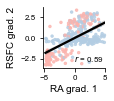

In [18]:
plt.figure(figsize=(1.6,1.5))
ax = sns.regplot(x=rsm_gradients[:,0],y=parcellated_gradients[:,1],color='k',scatter_kws={'s':6,'color':roiColorsByNetwork,'clip_on':False})
# ax.set_clip_box(True)
# ax.set_clip_box(True)
plt.xlabel('RA grad. 1',fontsize=10)
plt.ylabel('RSFC grad. 2',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-5.2,5])
rho, p = stats.pearsonr(parcellated_gradients[:,1],rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(rho),
             xy=(0.5,.1),fontsize=8,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'RAGradientXRSGradient2.pdf',transparent=True)

# BrainSmash RA Grad 1 X RSFC Grad 2

In [12]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../processed_data/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../processed_data/LeftParcelGeodesicDistmat.txt')
base = Base(rsm_gradients[:,0][:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(rsm_gradients[:,0][180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_rsm = np.hstack((surrogates_lh,surrogates_rh))

In [13]:
surrogate_brainmap_corrs = pearsonr(surrogates_rsm,parcellated_gradients[:,1]).flatten()
test_stat = stats.pearsonr(rsm_gradients[:,0],parcellated_gradients[:,1])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between RA Grad 1 and RSFC Grad 2: r =', r, '| p =', p)


Correlation between RA Grad 1 and RSFC Grad 2: r = 0.5898167103028179 | p = 0.0


# Plot dimensionality of each network, sorted by hierarchy

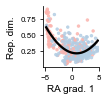

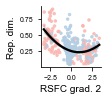

In [20]:

plt.figure(figsize=(1.6,1.5))
sns.regplot(x=rsm_gradients[:,0],y=avg_dim,color='k',order=2,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RA grad. 1',fontsize=10)
plt.ylabel('Rep. dim.',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlim([-5.4,5])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'Dimensionality_X_RAGradient.pdf',transparent=True)

plt.figure(figsize=(1.6,1.5))
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,color='k',order=2,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.ylabel('Rep. dim.',fontsize=10)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.6,3.5])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'Dim_X_RSGradient2.pdf',transparent=True)

# Plot dimensionality, sorted by RA gradient bins

In [21]:
n_hierarchy_bins = 10
bin_stepsize = 36
sorted_hierarchy = sorted(range(len(rsm_gradients[:,0])), key=lambda k: rsm_gradients[:,0][k])

df = {}
df['Dimensionality'] = []
df['Parcel'] = []
df['Hierarchy'] = []

binstart = 0
for bins in range(n_hierarchy_bins):
    bin_ind = np.asarray(sorted_hierarchy[binstart:(binstart+bin_stepsize)])
    for roi in bin_ind:
        df['Dimensionality'].append(avg_dim[roi])
        df['Parcel'].append(roi)
        df['Hierarchy'].append(bins+1)
                           
    
    binstart += bin_stepsize
    
dimensionality_hierarchy = pd.DataFrame(df)




/Users/ti236/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.962
Model:                            OLS   Adj. R-squared:                  0.952
Method:                 Least Squares   F-statistic:                     89.76
Date:                Tue, 25 Oct 2022   Prob (F-statistic):           1.02e-05
Time:                        14:34:35   Log-Likelihood:                 24.308
No. Observations:                  10   AIC:                            -42.62
Df Residuals:                       7   BIC:                            -41.71
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2132      0.016     13.514      0.000       0.176       0.251
x1            -0.1852      0.015    -12.513      0.000      -0.220      -0.150
x2             0.0097      0.004      2.549      0.038       0.001       0.019
==============================================================================
Omnibus:                        2.689   Durbin-Watson:                   3.143
Prob(Omnibus):                  0.261   Jarque-Bera (JB):                1.014
Skew:                          -0.271   Prob(JB):                        0.602
Kurtosis:                       1.537   Cond. No.                         9.40
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

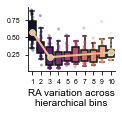

In [23]:

########################################
### Piece-wise regression on RSFC Gradient 2
y = dimensionality_hierarchy.groupby('Hierarchy').mean().Dimensionality.values
rsquared = []
coef1 = []
coef2 = []
x = np.arange(1,n_hierarchy_bins+1)
kinks = np.arange(2,n_hierarchy_bins)
for i in kinks:
    # piecewise linear data prepare
    x1 = np.where(x < i, x - i, 0)
    x2 = np.where(x >= i, x - i, 0)
    dtest = pd.DataFrame([y, x, x1, x2]).T
    dtest.columns = ['y', 'x', 'x1', 'x2']

    # piecewise linear regression
    f2 = smf.ols(formula = 'y ~ x1 + x2', data = dtest).fit()
    y_predict = f2.predict()    

    rsquared.append(f2.rsquared_adj)
    coef1.append(f2.params.x1)
    coef2.append(f2.params.x2)
    
best_fit = np.argmax(rsquared)

### Now plot best fit model
i = kinks[best_fit]
# piecewise linear data prepare
x1 = np.where(x < i, x - i, 0)
x2 = np.where(x >= i, x - i, 0)
dtest = pd.DataFrame([y, x, x1, x2]).T
dtest.columns = ['y', 'x', 'x1', 'x2']

f2 = smf.ols(formula = 'y ~ x1 + x2', data = dtest).fit()
y_predict = f2.predict()  

plt.figure(figsize=(1.8,1.7))
plt.plot(x-1,y_predict,color='r',linewidth=2)
sns.lineplot(x=x-1,y=y_predict,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
tmpx = [0, i-1, x[-1]-1]
tmpy = y_predict[np.asarray(tmpx)]
sns.scatterplot(x=tmpx,y=tmpy,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
ax = sns.boxplot(x="Hierarchy",y="Dimensionality",sym='',whis=[2.5,97.5],data=dimensionality_hierarchy,palette='magma',zorder=0) #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="Hierarchy",y="Dimensionality",alpha=0.4,s=3,data=dimensionality_hierarchy,palette='magma',zorder=0)
plt.xticks(fontsize=10);
plt.xlabel('RA variation across\nhierarchical bins',fontsize=10);
plt.ylabel(None)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'DimensionalityXRSMSimilarityGradient.pdf',transparent=True)

f2.summary()


# Compare dimensionality by system

Sensory vs. Association: t = 7.218049445426947 | p = 3.880328735493864e-12 | df = 319
Motor vs. Association: t = 2.5868508946139332 | p = 0.01018497584938526 | df = 283


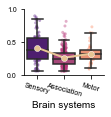

In [24]:
df_system = {}
df_system['Dimensionality'] = []
df_system['System'] = []
df_system['Parcel'] = []

for net in sensorynets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim[roi])
        df_system['System'].append('Sensory')
        df_system['Parcel'].append(roi)

for net in associationnets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim[roi])
        df_system['System'].append('Association')
        df_system['Parcel'].append(roi)
        
for net in motornets:
    rois = np.where(networkdef==networkmappings[net])[0]
    for roi in rois:
        df_system['Dimensionality'].append(avg_dim[roi])
        df_system['System'].append('Motor')
        df_system['Parcel'].append(roi)


df_system = pd.DataFrame(df_system)


plt.figure(figsize=(1.7,1.7))
ax = sns.boxplot(x="System",y="Dimensionality",sym='',whis=[2.5,97.5],data=df_system,palette='magma') #,order=hierarchy_ind,palette=networkpalette)
sns.stripplot(x="System",y="Dimensionality",alpha=0.4,s=3,data=df_system,palette='magma',zorder=0)
tmp = df_system.groupby('System',sort=False).mean()
y = tmp.Dimensionality.values
sns.lineplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],linewidth=2,zorder=4)
sns.scatterplot(x="System",y="Dimensionality",data=tmp,markers=["o"],color=sns.color_palette("Set2")[6],zorder=4)
plt.xticks(fontsize=10);
plt.xlabel('Brain systems',fontsize=10);
plt.ylabel(None)
plt.xticks(fontsize=7,rotation=-15)
plt.yticks(fontsize=7)
plt.tight_layout()
plt.ylim([0,1])
sns.despine()
plt.savefig(figuredir + 'DimensionalityXBrainSystems.pdf',transparent=True)

# Statistical testing
df_assoc = df_system.loc[df_system.System=='Association']
df_sensory = df_system.loc[df_system.System=='Sensory']
df_motor = df_system.loc[df_system.System=='Motor']

t, p = stats.ttest_ind(df_sensory.Dimensionality.values,df_assoc.Dimensionality.values)
print('Sensory vs. Association: t =', t, '| p =', p, '| df =', len(df_sensory.Dimensionality.values) + len(df_assoc.Dimensionality.values)-2)
t, p = stats.ttest_ind(df_motor.Dimensionality.values,df_assoc.Dimensionality.values)
print('Motor vs. Association: t =', t, '| p =', p, '| df =', len(df_motor.Dimensionality.values) + len(df_assoc.Dimensionality.values)-2)


# Compare AIC/BIC of 2nd v 1st order model of Dimensionality vs. RA gradient & Supplementary analyses

AIC/BIC of model order 1 -326.18598039713095 / -318.41377233423066
AIC/BIC of model order 2 -441.5916294940117 / -429.93331739966123
AIC/BIC of exponential decay fit -356.2756699589564 / -348.50346189605614
AIC/BIC of RS model piece-wise regression -253.60317436676758 / -245.83096630386726
Delta AIC, order 2 v 1 -115.40564909688078
Delta BIC, order 2 v 1 -111.51954506543058


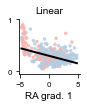

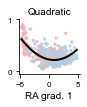

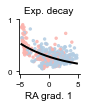

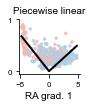

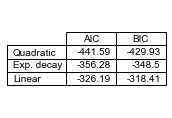

In [27]:
df_aic_bic_ra = {}
df_aic_bic_ra['AIC'] = []
df_aic_bic_ra['BIC'] = []
df_aic_bic_ra['Model'] = []
#

x = rsm_gradients[:,0]
x.shape = (len(x),1)

#################################################
## Run 1st order model (linear model)
polynomial_features = PolynomialFeatures(degree=1)
xp1_ra = polynomial_features.fit_transform(x)

y = avg_dim
#fit regression model
ra_model1 = sm.OLS(y, xp1_ra).fit()
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(xp1_ra[:,1])
plt.plot(xp1_ra[sorted_ind,1],ra_model1.predict(xp1_ra)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=rsm_gradients[:,0],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RA grad. 1',fontsize=10)
plt.title('Linear',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
sns.despine()
plt.tight_layout()
plt.savefig('../figures/SFig5/RA_LinearModel.pdf',transparent=True)


########################################
## 2nd order model
polynomial_features = PolynomialFeatures(degree=2)
xp2 = polynomial_features.fit_transform(x)

y = avg_dim
#fit regression model
ra_model2 = sm.OLS(y, xp2).fit()
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(xp2[:,1])
plt.plot(xp2[sorted_ind,1],ra_model2.predict(xp2)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=rsm_gradients[:,0],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RA grad. 1',fontsize=10)
plt.title('Quadratic',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RA_QuadraticModel.pdf',transparent=True)


########################################
### Try exponential decay fit
def exponentialdecay(x,n0,decay):
    return n0*np.exp(-decay*x)
params = scipy.optimize.curve_fit(exponentialdecay,x[:,0],y,method='trf')[0]
ypred = exponentialdecay(x[:,0],params[0],params[1])
lln = calc_loglikelihood(len(y), y, ypred)
exp_aic = 2*len(params) - 2*lln
exp_bic = np.log(len(y))*len(params) - 2*lln
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(x[:,0])
plt.plot(x[:,0][sorted_ind],ypred[sorted_ind],color='k',linewidth=2)
sns.regplot(x=rsm_gradients[:,0],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RA grad. 1',fontsize=10)
plt.title('Exp. decay',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RA_ExpModel.pdf',transparent=True)

########################################
### Piece-wise regression on RSFC Gradient 2

x_1st_ind = np.where(x<0)[0]
x_2nd_ind = np.where(x>0)[0]

x1 = np.zeros((len(x),1))
x2 = np.zeros((len(x),1))
x1[x_1st_ind] = x[x_1st_ind]
x2[x_2nd_ind] = x[x_2nd_ind]
xp = np.hstack((x1,x2))

## Run 1st split median
y = avg_dim
#fit regression model
ra_piecewise_model = sm.OLS(y, xp).fit()
#
plt.figure(figsize=(1.4,1.6))
x_new = np.sum(xp,axis=1)
sorted_ind = np.argsort(x_new)
plt.plot(x_new[sorted_ind],ra_piecewise_model.predict(xp)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=rsm_gradients[:,0],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RA grad. 1',fontsize=10)
plt.title('Piecewise linear',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RA_PiecewiseLinearModel.pdf',transparent=True)

############################################
#view AIC of model
print('AIC/BIC of model order 1', ra_model1.aic, '/', ra_model1.bic)
print('AIC/BIC of model order 2', ra_model2.aic, '/', ra_model2.bic)
print('AIC/BIC of exponential decay fit', exp_aic, '/', exp_bic)
print('AIC/BIC of RS model piece-wise regression', ra_piecewise_model.aic, '/', ra_piecewise_model.bic)
print('Delta AIC, order 2 v 1', ra_model2.aic - ra_model1.aic)
print('Delta BIC, order 2 v 1', ra_model2.bic - ra_model1.bic)

# Add to dataframe
df_aic_bic_ra['Model'].append('Linear')
df_aic_bic_ra['AIC'].append(round(ra_model1.aic,2))
df_aic_bic_ra['BIC'].append(round(ra_model1.bic,2))
#
df_aic_bic_ra['Model'].append('Quadratic')
df_aic_bic_ra['AIC'].append(round(ra_model2.aic,2))
df_aic_bic_ra['BIC'].append(round(ra_model2.bic,2))
#
df_aic_bic_ra['Model'].append('Exp. decay')
df_aic_bic_ra['AIC'].append(round(exp_aic,2))
df_aic_bic_ra['BIC'].append(round(exp_bic,2))
#
df_aic_bic_ra = pd.DataFrame(df_aic_bic_ra)
df_aic_bic_ra = df_aic_bic_ra.set_index('Model')
df_aic_bic_ra = df_aic_bic_ra.sort_values(by="AIC")

# fig, ax = plt.subplots(figsize=(3,2))
fig, ax = plt.subplots(figsize=(2.5,1.75))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=df_aic_bic_ra.values, rowLabels=df_aic_bic_ra.index, colLabels=df_aic_bic_ra.columns, loc='center',fontsize=10)
fig.tight_layout()
fig.savefig('../figures/SFig5/AICBIC_Table_RA.pdf',transparent=True)

#### Compare AIC/BIC of 2nd v 1st order model of Dimensionality vs. RS Gradient 2

AIC/BIC of RS model order 1 -306.01990466949303 / -298.24769660659274
AIC/BIC of RS model order 2 -356.42838186780034 / -344.77006977344985
AIC/BIC of exponential decay fit -320.7355912761857 / -312.9633832132854
AIC/BIC of RS model piece-wise regression -115.58099853465444 / -107.80879047175412
Delta AIC, order 2 v 1 -50.40847719830731
Delta BIC, order 2 v 1 -46.52237316685711


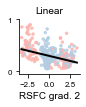

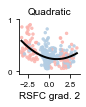

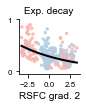

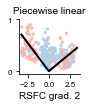

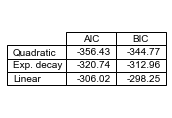

In [28]:
df_aic_bic_rsfc = {}
df_aic_bic_rsfc['AIC'] = []
df_aic_bic_rsfc['BIC'] = []
df_aic_bic_rsfc['Model'] = []

#
x = parcellated_gradients[:,1]
x.shape = (len(x),1)

#################################################
## Run 1st order model (linear model)
polynomial_features = PolynomialFeatures(degree=1)
xp1_rest = polynomial_features.fit_transform(x)

y = avg_dim
#fit regression model
rs_model1 = sm.OLS(y, xp1_rest).fit()
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(xp1_rest[:,1])
plt.plot(xp1_rest[sorted_ind,1],rs_model1.predict(xp1_rest)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.title('Linear',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RSFC_LinearModel.pdf',transparent=True)


########################################
## 2nd order model
polynomial_features = PolynomialFeatures(degree=2)
xp2_rest = polynomial_features.fit_transform(x)

y = avg_dim
#fit regression model
rs_model2 = sm.OLS(y, xp2_rest).fit()
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(xp2_rest[:,1])
plt.plot(xp2_rest[sorted_ind,1],rs_model2.predict(xp2_rest)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.title('Quadratic',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RSFC_QuadraticModel.pdf',transparent=True)
# 

########################################
### Try exponential decay fit
def exponentialdecay(x,n0,decay):
    return n0*np.exp(-decay*x)
params = scipy.optimize.curve_fit(exponentialdecay,x[:,0],y,method='trf')[0]
ypred = exponentialdecay(x[:,0],params[0],params[1])
lln = calc_loglikelihood(len(y), y, ypred)
exp_aic = 2*len(params) - 2*lln
exp_bic = np.log(len(y))*len(params) - 2*lln
#
#
## PLOT
plt.figure(figsize=(1.4,1.6))
sorted_ind = np.argsort(x[:,0])
plt.plot(x[:,0][sorted_ind],ypred[sorted_ind],color='k',linewidth=2)
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.title('Exp. decay',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RSFC_ExpModel.pdf',transparent=True)

########################################
### Piece-wise regression on RSFC Gradient 2

x_1st_ind = np.where(x<0)[0]
x_2nd_ind = np.where(x>0)[0]

x1 = np.zeros((len(x),1))
x2 = np.zeros((len(x),1))
x1[x_1st_ind] = x[x_1st_ind]
x2[x_2nd_ind] = x[x_2nd_ind]
xp = np.hstack((x1,x2))

## Run 1st split median
y = avg_dim
#fit regression model
rs_piecewise_model = sm.OLS(y, xp).fit()
#
plt.figure(figsize=(1.4,1.6))
x_new = np.sum(xp,axis=1)
sorted_ind = np.argsort(x_new)
plt.plot(x_new[sorted_ind],rs_piecewise_model.predict(xp)[sorted_ind],color='k',linewidth=2)
sns.regplot(x=parcellated_gradients[:,1],y=avg_dim,fit_reg=False,scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.xlabel('RSFC grad. 2',fontsize=10)
plt.title('Piecewise linear',fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.ylim([-0.05,1.0])
rho, p = stats.spearmanr(avg_dim,rsm_gradients[:,0])
rho = round(rho,2)
p = round(p,2)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig5/RSFC_PiecewiseLinearModel.pdf',transparent=True)

############################################
#view AIC of model
print('AIC/BIC of RS model order 1', rs_model1.aic, '/', rs_model1.bic)
print('AIC/BIC of RS model order 2', rs_model2.aic, '/', rs_model2.bic)
print('AIC/BIC of exponential decay fit', exp_aic, '/', exp_bic)
print('AIC/BIC of RS model piece-wise regression', rs_piecewise_model.aic, '/', rs_piecewise_model.bic)
print('Delta AIC, order 2 v 1', rs_model2.aic - rs_model1.aic)
print('Delta BIC, order 2 v 1', rs_model2.bic - rs_model1.bic)

# Add to dataframe
df_aic_bic_rsfc['Model'].append('Linear')
df_aic_bic_rsfc['AIC'].append(round(rs_model1.aic,2))
df_aic_bic_rsfc['BIC'].append(round(rs_model1.bic,2))
#
df_aic_bic_rsfc['Model'].append('Quadratic')
df_aic_bic_rsfc['AIC'].append(round(rs_model2.aic,2))
df_aic_bic_rsfc['BIC'].append(round(rs_model2.bic,2))
#
df_aic_bic_rsfc['Model'].append('Exp. decay')
df_aic_bic_rsfc['AIC'].append(round(exp_aic,2))
df_aic_bic_rsfc['BIC'].append(round(exp_bic,2))
#

df_aic_bic_rsfc = pd.DataFrame(df_aic_bic_rsfc)
df_aic_bic_rsfc = df_aic_bic_rsfc.set_index('Model')
df_aic_bic_rsfc = df_aic_bic_rsfc.sort_values(by="AIC")

fig, ax = plt.subplots(figsize=(2.5,1.75))
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
table = ax.table(cellText=df_aic_bic_rsfc.values, rowLabels=df_aic_bic_rsfc.index, colLabels=df_aic_bic_rsfc.columns, loc='center',fontsize=10)
fig.tight_layout()
fig.savefig('../figures/SFig5/AICBIC_Table_RSF C.pdf',transparent=True)

# Supplementary analyses?

# Plot the RSMs on opposite axes of Margulies gradient 2 and identify on surface

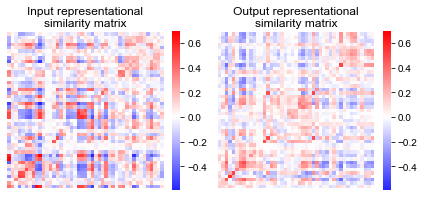

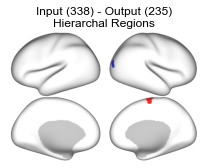

In [32]:
h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()
h5f.close()
# Average across subjects
rsms_avg = np.mean(rsms_subj,axis=1)

in_ind = np.where(parcellated_gradients[:,1]==np.min(parcellated_gradients[:,1]))[0][0]
out_ind = np.where(parcellated_gradients[:,1]==np.max(parcellated_gradients[:,1]))[0][0]

in_rsm = rsms_avg[in_ind,:,:]
out_rsm = rsms_avg[out_ind,:,:]

vmin, vmax = np.min([in_rsm,out_rsm]), np.max([in_rsm,out_rsm])

plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
ax = sns.heatmap(in_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Input representational\nsimilarity matrix',fontsize=12)

plt.subplot(1,2,2)
ax = sns.heatmap(out_rsm,square=True,vmin=vmin,vmax=vmax,center=0,cmap='bwr',cbar_kws={'fraction':0.046})
ax.invert_yaxis()
plt.xticks([])
plt.yticks([])
plt.title('Output representational\nsimilarity matrix',fontsize=12)
plt.tight_layout()
plt.savefig('../figures/Fig6/InputAndOutputRSM.png',dpi=300)



#####
# Plot on surface
tmp_parcels = np.zeros((nParcels,))
tmp_parcels[in_ind] = -1
tmp_parcels[out_ind] = 1
if not os.path.exists('../figures/Fig6/InputOutputHierarchicalRegions.png'):
    tmp = np.hstack((tmp_parcels[180:],tmp_parcels[:180]))
#     tmp = stats.zscore(tmp)
#     vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar('../figures/Fig6/InputOutputHierarchicalRegions.png',tmp,cmap='bwr')


fig = plt.figure(figsize=(3,3))

im = img.imread('../figures/Fig6/InputOutputHierarchicalRegions.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Input (' + str(in_ind+1) + ') - Output (' + str(out_ind+1) + ')\nHierarchal Regions',fontsize=12)
plt.tight_layout()
plt.savefig('../figures/Fig6/InputOutputRegionsMarguliesGradient2.png',dpi=300)